In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
Plantdataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(256,256),
    batch_size=32
)

Found 2152 files belonging to 3 classes.


In [22]:
classes = Plantdataset.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(Plantdataset)

68

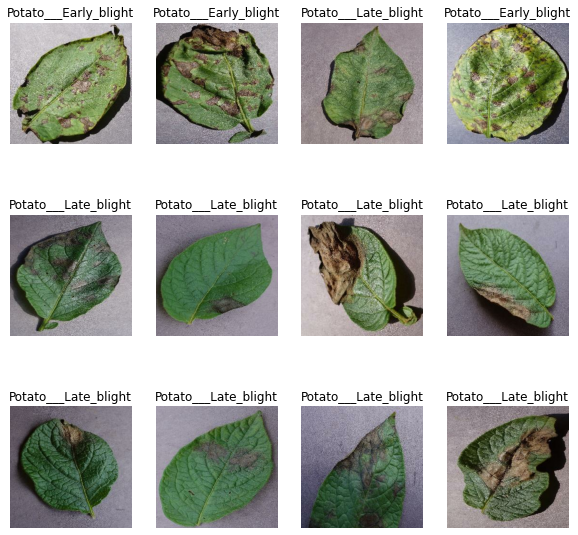

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in Plantdataset.take(1):
    for i in range(12):
        sb = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classes[label_batch[i]])
        plt.axis("off")

In [7]:
train_size = 0.8
len(Plantdataset)*train_size

54.400000000000006

In [8]:
train_ds = Plantdataset.take(54)
len(train_ds)

54

In [9]:
test_ds = Plantdataset.skip(54)
len(test_ds)

14

In [10]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [11]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [12]:
def datasetPartition(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle=True, shuffle_size = 10000):
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = datasetPartition(Plantdataset)

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resizing = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/255)

])

In [16]:
augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),

])

In [17]:
input_shape = (32,256,256,3)
classes = 3

model = models.Sequential([
    resizing,
    augmentation,
    layers.Conv2D(32,(3,3),activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(classes,activation='softmax'),
])
model.build(input_shape = input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
trainingModel = model.fit(
    train_ds,
    epochs=5,
    batch_size = 32,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/5
54/54 [==============================] - 117s 2s/step - loss: 0.8948 - accuracy: 0.5712 - val_loss: 0.7856 - val_accuracy: 0.6875
Epoch 2/5
54/54 [==============================] - 109s 2s/step - loss: 0.7012 - accuracy: 0.7153 - val_loss: 0.5606 - val_accuracy: 0.7500
Epoch 3/5
54/54 [==============================] - 102s 2s/step - loss: 0.5044 - accuracy: 0.7980 - val_loss: 0.3374 - val_accuracy: 0.8333
Epoch 4/5
54/54 [==============================] - 104s 2s/step - loss: 0.3346 - accuracy: 0.8692 - val_loss: 0.3893 - val_accuracy: 0.8229
Epoch 5/5
54/54 [==============================] - 98s 2s/step - loss: 0.3102 - accuracy: 0.8843 - val_loss: 0.3322 - val_accuracy: 0.8802


first image prediction
actual class: Potato___Early_blight
predicted class: Potato___Early_blight


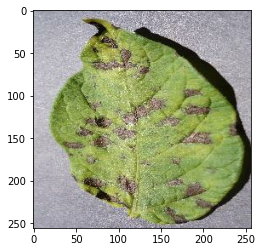

In [23]:
import numpy as np
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    print("first image prediction")
    plt.imshow(first_image)
    print("actual class:", classes[first_label])
    batch_prediction = model.predict(image_batch)
    print("predicted class:",classes[np.argmax(batch_prediction[0])])
    
    
    

In [24]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    predictions = model.predict(img_array)
    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

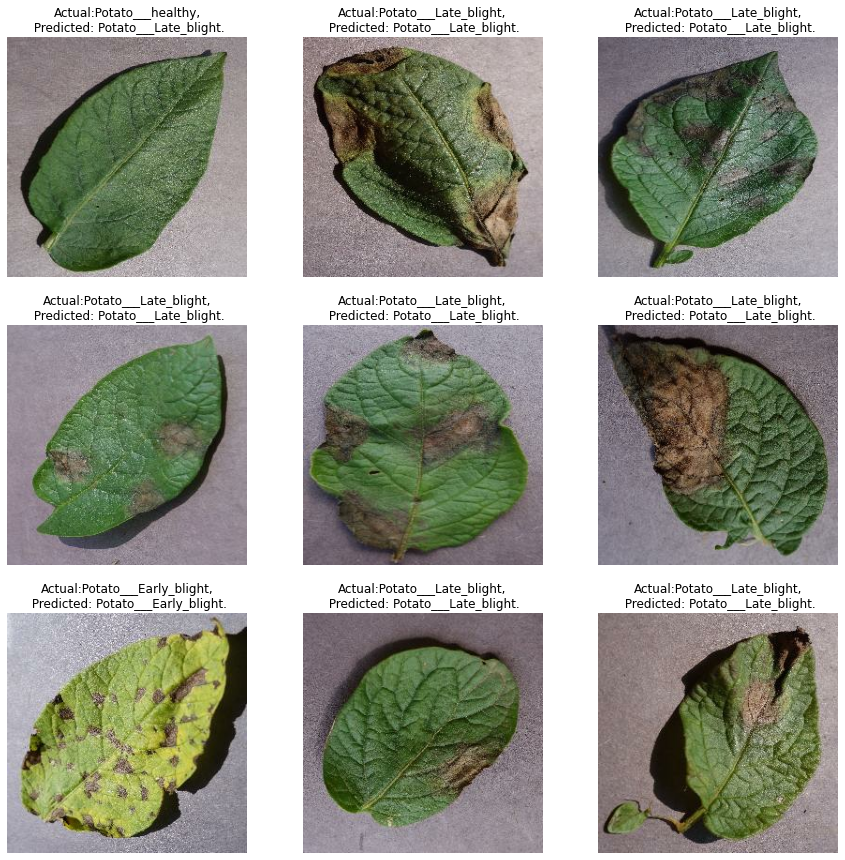

In [25]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        axis=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=classes[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class}.")
        plt.axis("off")

In [26]:
import os 

model_version = max([int(i) for i in os.listdir("../savedmodel")+[0]])+1
model.save(f"../savedmodel/{model_version}")

INFO:tensorflow:Assets written to: ../savedmodel/9\assets


In [33]:
os.getcwd()

'C:\\Users\\91958\\Desktop\\Plant Disease\\training'